# Capstone

## Loading Data

In [1]:
#remove this comment later 1st try

In [2]:
# creates dir for kaggle 
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


In [3]:
# Download Data
!kaggle datasets download navoneel/brain-mri-images-for-brain-tumor-detection
!ls

 99% 15.0M/15.1M [00:00<00:00, 49.6MB/s]
100% 15.1M/15.1M [00:00<00:00, 59.8MB/s]
brain-mri-images-for-brain-tumor-detection.zip	sample_data


In [4]:
!unzip brain-mri-images-for-brain-tumor-detection.zip

Archive:  brain-mri-images-for-brain-tumor-detection.zip
  inflating: brain_tumor_dataset/no/1 no.jpeg  
  inflating: brain_tumor_dataset/no/10 no.jpg  
  inflating: brain_tumor_dataset/no/11 no.jpg  
  inflating: brain_tumor_dataset/no/12 no.jpg  
  inflating: brain_tumor_dataset/no/13 no.jpg  
  inflating: brain_tumor_dataset/no/14 no.jpg  
  inflating: brain_tumor_dataset/no/15 no.jpg  
  inflating: brain_tumor_dataset/no/17 no.jpg  
  inflating: brain_tumor_dataset/no/18 no.jpg  
  inflating: brain_tumor_dataset/no/19 no.jpg  
  inflating: brain_tumor_dataset/no/2 no.jpeg  
  inflating: brain_tumor_dataset/no/20 no.jpg  
  inflating: brain_tumor_dataset/no/21 no.jpg  
  inflating: brain_tumor_dataset/no/22 no.jpg  
  inflating: brain_tumor_dataset/no/23 no.jpg  
  inflating: brain_tumor_dataset/no/24 no.jpg  
  inflating: brain_tumor_dataset/no/25 no.jpg  
  inflating: brain_tumor_dataset/no/26 no.jpg  
  inflating: brain_tumor_dataset/no/27 no.jpg  
  inflating: brain_tumor_datase

---

## Exploratory Data Analysis

In [5]:
# import libraries
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf
import pathlib

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from PIL import ImageOps, Image

In [6]:
all_data_dir = pathlib.Path('/content/brain_tumor_dataset')
yes_dir = pathlib.Path('/content/yes')
no_dir = pathlib.Path('/content/no')

In [7]:
dataCount = len(list(all_data_dir.glob('*')))
print(dataCount)
yesCount = len(list(yes_dir.glob('*')))
print(yesCount)
noCount = len(list(no_dir.glob('*')))
print(noCount)

2
155
98


In [8]:
image_count = len(list(all_data_dir.glob('*/*')))
print(image_count)

253


In [9]:
target_height = 100
target_width = 100

In [10]:
image_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    target_size=(target_height, target_width),
    directory=all_data_dir,
    batch_size=128,
    image_data_generator=None)

Found 253 images belonging to 2 classes.


In [11]:
arr = image_iterator.filepaths

# j=0

for i in arr: 
  image = i
  img = PIL.Image.open(image)
  img = img.convert('RGB')
  img = img.resize((target_height, target_width), Image.ANTIALIAS)
  flip = ImageOps.flip(img)
  mirror = ImageOps.mirror(img)
  rotate = img.rotate(180)

  # if j < 10:
  #   plt.figure()
  #   plt.imshow(img)
  #   plt.figure()
  #   plt.imshow(flip)
  #   plt.figure()
  #   plt.imshow(mirror)
  #   plt.figure()
  #   plt.imshow(rotate)
  #   j += 1
  
  new = i.strip('.jpeg')
  #new = i.strip('.jpg')
  name = new + '-flipped.jpeg'
  name2 = new + '-mirror.jpeg'
  name3 = new + '-rotate.jpeg'
  flip.save(name)
  mirror.save(name2)
  rotate.save(name3)
  # overwrites resized image into dir
  img.save(i)


In [246]:
image_iterator = tf.keras.preprocessing.image.DirectoryIterator(
    target_size=(target_height, target_width),
    directory=all_data_dir,
    batch_size=128,
    image_data_generator=None)

Found 1012 images belonging to 2 classes.


## Splitting Data

In [254]:
split_size = .2
batch_size = np.round(image_iterator.n * split_size)
img_height = 100
img_width = 100
print(batch_size)

202.0


In [255]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=split_size,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1012 files belonging to 2 classes.
Using 810 files for training.


In [256]:
train_labels = np.concatenate([y for x, y in train_ds], axis=0)
train_labels.size

810

In [292]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  all_data_dir,
  #labels=None,
  validation_split=split_size,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1012 files belonging to 2 classes.
Using 202 files for validation.


In [293]:
val_labels = np.concatenate([y for x, y in val_ds], axis=0)
val_labels.size

202

In [295]:
val_labels

array([0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1,
       0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0,
       0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1], dtype=int32)

In [296]:
class_names = train_ds.class_names
print('train class names =', class_names)
class_names = val_ds.class_names
print('val class names =', class_names)

train class names = ['no', 'yes']
val class names = ['no', 'yes']


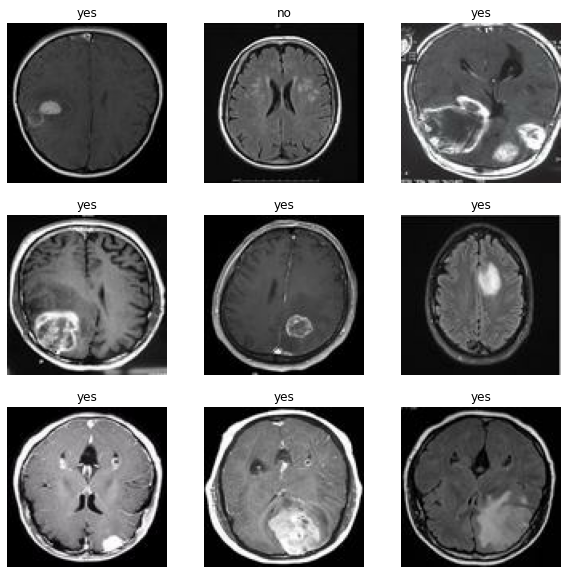

In [261]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

<class 'tensorflow.python.framework.ops.EagerTensor'>
<class 'tensorflow.python.framework.ops.EagerTensor'>


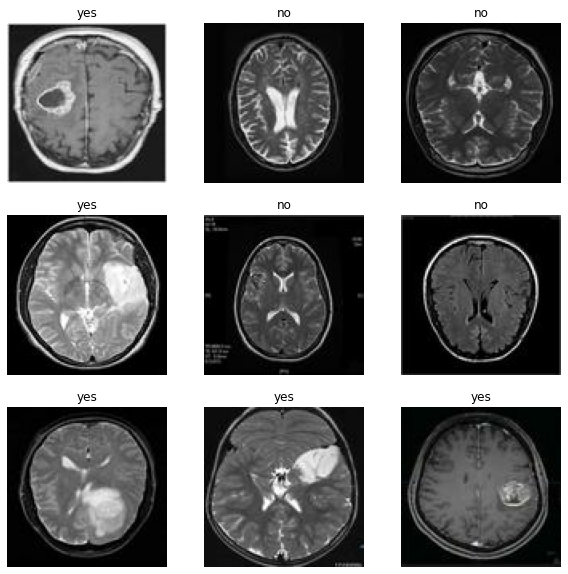

In [39]:
# import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     plt.imshow(images[i].numpy().astype("uint8"))
#     plt.title(class_names[labels[i]])
#     plt.axis("off")

## Build And Train Model

In [17]:
num_classes = 1

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, activation='sigmoid')
])

In [18]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 100, 100, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0

In [19]:
epochs=10

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
26/26 [==============================] - 16s 25ms/step - loss: 0.5906 - accuracy: 0.6938 - val_loss: 0.5212 - val_accuracy: 0.7673
Epoch 2/10
26/26 [==============================] - 0s 15ms/step - loss: 0.4991 - accuracy: 0.7827 - val_loss: 0.4592 - val_accuracy: 0.8218
Epoch 3/10
26/26 [==============================] - 0s 15ms/step - loss: 0.4485 - accuracy: 0.7975 - val_loss: 0.4934 - val_accuracy: 0.7723
Epoch 4/10
26/26 [==============================] - 0s 16ms/step - loss: 0.4024 - accuracy: 0.8222 - val_loss: 0.3438 - val_accuracy: 0.8564
Epoch 5/10
26/26 [==============================] - 0s 15ms/step - loss: 0.2983 - accuracy: 0.8815 - val_loss: 0.2730 - val_accuracy: 0.8911
Epoch 6/10
26/26 [==============================] - 0s 16ms/step - loss: 0.2575 - accuracy: 0.8901 - val_loss: 0.3078 - val_accuracy: 0.8713
Epoch 7/10
26/26 [==============================] - 0s 16ms/step - loss: 0.2071 - accuracy: 0.9049 - val_loss: 0.3257 - val_accuracy: 0.8663
Epoch 8/10
2

## Checking Model Accuracy

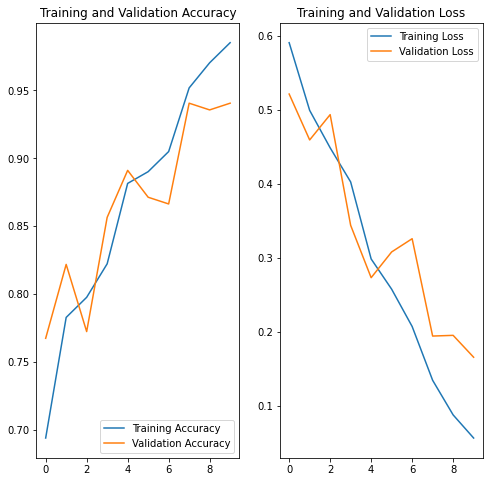

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
model.evaluate(val_ds)

7/7 [==============================] - 0s 5ms/step - loss: 0.1655 - accuracy: 0.9406


[0.1654842346906662, 0.9405940771102905]

## Predictions

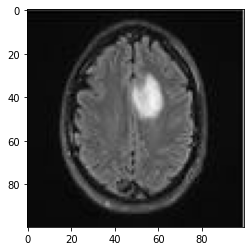

Prediction: [1.]
Actual: tf.Tensor(1, shape=(), dtype=int32)

classification report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        79
           1       1.00      0.98      0.99       123

    accuracy                           0.99       202
   macro avg       0.99      0.99      0.99       202
weighted avg       0.99      0.99      0.99       202

confusion matrix:


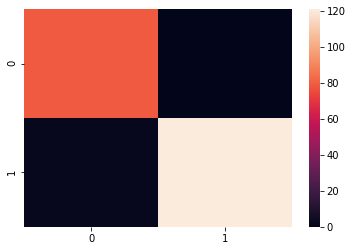

In [438]:
import random
import math
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

num = random.randint(0, len(image_batch)-1)
plt.imshow(image_batch[num].numpy().astype('uint8'))
plt.show()
predictions = model.predict(image_batch)
rounded_predictions = abs(np.round(predictions - .25))
# print(predictions)
# print(rounded_predictions)
#rounded_labels = np.argmax(label_batch)
# print(label_batch)

print('Prediction:', rounded_predictions[num])
print('Actual:', label_batch[num])

print('\nclassification report:')
print(classification_report(label_batch, rounded_predictions))

print('confusion matrix:')
cm = confusion_matrix(label_batch, rounded_predictions)
sns.heatmap(cm, xticklabels=[0, 1], yticklabels=[0,1])